# FinBERT + Stock Extraction + Trading Signal Generation
## Enhanced Sentiment Analysis with Trading Signals

### Project Overview:
1. **FinBERT Integration**: Replace traditional sentiment models with FinBERT (pre-trained on financial text)
2. **Stock Name Extraction**: Use NER to extract stock names from news articles
3. **Trading Signal Generation**: Combine sentiment + stock info to generate buy/sell/hold signals
4. **Backtesting**: Simulate trading performance

---

**Author**: HARSHA VARDHAN K  
**Date**: October 2025  
**Dataset**: Indian Financial News


## CELL 1: Import Libraries & Setup


^C
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   - -------------------------------------- 3.9/109.3 MB 21.5 MB/s eta 0:00:05
   - -------------------------------------- 5.0/109.3 MB 12.1 MB/s eta 0:00:09
   -- ------------------------------------- 5.5/109.3 MB 8.6 MB/s eta 0:00:13
   -- ------------------------------------- 6.3/109.3 MB 7.6 MB/s eta 0:00:14
   -- ------------------------------------- 7.3/109.3 MB 6.7 MB/s eta 0:00:16
   --- ------------------------------------ 8.7/109.3 MB 6.2 MB/s eta 0:00:17
   --- ------------------------------------ 10.0/109.3 MB 6.2 MB/s eta 0:00:16
   ---- ----------------------------------- 11.5/109.3 MB 6.4 MB/s eta 0:00:16
   ---- ----------------------------------- 12.1/109.3 MB 6.0 MB/s eta 0:00:17
   ---- ----------------------------------- 12.8/109.3 MB 5.8 MB/s eta 0:00:17
   ----- ---------------------------------- 14.2/109.3 MB 5.7 MB/

In [ ]:
# CELL 1: Import all required libraries (LIGHTWEIGHT VERSION)
print("⏳ Loading libraries...")

# Basic libraries (fast)
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
print("✅ Basic libraries")

# Dataset loading
from datasets import load_dataset
print("✅ Dataset library")

# BETTER SENTIMENT (VADER - optimized for financial/social media text)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
print("✅ VADER for sentiment (better for financial text)")

# Stock extraction
from collections import Counter
print("✅ Collections library")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
print("✅ Visualization libraries")

# Optional: Try to import spacy for NER (if available)
try:
    import spacy
    print("✅ spaCy for NER (optional)")
    nlp_available = True
except:
    print("⚠️  spaCy not available, using regex fallback")
    nlp_available = False

print("\n" + "="*80)
print("🎉 ALL LIBRARIES LOADED SUCCESSFULLY!")
print("="*80)
print(f"Timestamp: {datetime.now()}")
print("\n💡 Using TextBlob instead of FinBERT (faster, no heavy dependencies!)")


⏳ Loading libraries...
✅ Basic libraries
✅ Dataset library
✅ TextBlob for sentiment (lightweight, fast)
✅ Collections library
✅ Visualization libraries
✅ spaCy for NER (optional)

🎉 ALL LIBRARIES LOADED SUCCESSFULLY!
Timestamp: 2025-10-27 20:34:23.866715

💡 Using TextBlob instead of FinBERT (faster, no heavy dependencies!)


## CELL 2: Load & Explore Dataset


In [24]:
# CELL 2: Load and explore the Indian Financial News dataset
print("\n" + "="*80)
print("CELL 2: LOADING DATASET")
print("="*80)

# Load dataset
print("\n[STEP 1] Loading dataset from Hugging Face...")
ds = load_dataset("kdave/Indian_Financial_News")
df = pd.DataFrame(ds['train'])

# Sample data (same as your major.py)
negative_samples = df[df['Sentiment'] == 'Negative'].sample(n=7200, random_state=42)
neutral_samples = df[df['Sentiment'] == 'Neutral'].sample(n=5800, random_state=42)
positive_samples = df[df['Sentiment'] == 'Positive'].sample(n=6100, random_state=42)

df = pd.concat([negative_samples, neutral_samples, positive_samples], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Dataset loaded!")
print(f"Total samples: {len(df):,}")
print(f"Sentiment distribution:")
print(df['Sentiment'].value_counts())

# Display first few rows
print("\n[STEP 2] First 3 samples:")
print(df.head(3))



CELL 2: LOADING DATASET

[STEP 1] Loading dataset from Hugging Face...

✅ Dataset loaded!
Total samples: 19,100
Sentiment distribution:
Sentiment
Negative    7200
Positive    6100
Neutral     5800
Name: count, dtype: int64

[STEP 2] First 3 samples:
                                                 URL  \
0  https://www.moneycontrol.com/news/business/rea...   
1  https://www.businesstoday.in/sectors/auto/coro...   
2  https://economictimes.indiatimes.com/markets/s...   

                                             Content  \
0  7) City: Bengaluru | Country: India | Tuition ...   
1  MG Motor India on Monday reported retail sales...   
2  New Delhi: Markets regulator Sebi has eased ru...   

                                             Summary Sentiment  
0  technology companies will continue to prefer B...  Positive  
1  MG Motor India reports retail sales of 710 uni...   Neutral  
2  sebi has eased rules for offshore funds seekin...   Neutral  


## CELL 3: Basic Text Preprocessing


In [25]:
# CELL 3: Basic text cleaning (from your major.py preprocessing)
print("\n" + "="*80)
print("CELL 3: TEXT PREPROCESSING")
print("="*80)

def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Keep text mostly intact for FinBERT (minimal cleaning)
    text = text.strip()
    
    return text

print("\n[STEP 1] Cleaning text data...")
df['cleaned_text'] = df['Content'].apply(clean_text)

print(f"✅ Text cleaning completed!")
print(f"Total samples: {len(df):,}")

# Show example
print("\n[STEP 2] Example before/after:")
print(f"Original: {df['Content'].iloc[0][:100]}...")
print(f"Cleaned:  {df['cleaned_text'].iloc[0][:100]}...")



CELL 3: TEXT PREPROCESSING

[STEP 1] Cleaning text data...
✅ Text cleaning completed!
Total samples: 19,100

[STEP 2] Example before/after:
Original: 7) City: Bengaluru | Country: India | Tuition fees for international students: $100 per year (Image:...
Cleaned:  7) City: Bengaluru | Country: India | Tuition fees for international students: $100 per year (Image:...


## CELL 4: TextBlob Sentiment Analysis (No FinBERT needed!)


In [ ]:
# CELL 4: Initialize VADER Sentiment Analyzer
print("\n" + "="*80)
print("CELL 4: VADER SENTIMENT ANALYZER")
print("="*80)

print("\n[STEP 1] Initializing VADER...")
sia = SentimentIntensityAnalyzer()
print("✅ VADER initialized!")

# Test VADER with a sample
print("\n[STEP 2] Testing VADER with sample text...")
sample_text = "Company XYZ reported strong quarterly earnings with profit growth of 25%."
scores = sia.polarity_scores(sample_text)
print(f"Sample text: {sample_text}")
print(f"VADER scores: {scores}")

if scores['compound'] > 0.1:
    sentiment = "POSITIVE"
elif scores['compound'] < -0.1:
    sentiment = "NEGATIVE"
else:
    sentiment = "NEUTRAL"
print(f"Predicted sentiment: {sentiment}")



CELL 4: TEXTBLOB SENTIMENT ANALYSIS

[STEP 1] TextBlob is ready to use!
✅ No model loading needed - it's already initialized!

[STEP 2] Testing TextBlob with sample text...
Sample text: Company XYZ reported strong quarterly earnings with profit growth of 25%.
Sentiment polarity: 0.43
Predicted sentiment: POSITIVE


## CELL 5: Apply VADER Sentiment Analysis


In [ ]:
# CELL 5: Apply TextBlob sentiment analysis to all articles
print("\n" + "="*80)
print("CELL 5: TEXTBLOB SENTIMENT ANALYSIS")
print("="*80)

def analyze_sentiment_vader(text):
    """Analyze sentiment using VADER"""
    try:
        scores = sia.polarity_scores(str(text))
        compound = scores['compound']
        
        if compound > 0.1:
            return ('POSITIVE', compound)
        elif compound < -0.1:
            return ('NEGATIVE', compound)
        else:
            return ('NEUTRAL', compound)
    except Exception as e:
        return ('NEUTRAL', 0.0)

# Process dataset (or use subset for faster testing)
print("\n[STEP 1] Applying TextBlob sentiment analysis...")
print("(TextBlob is fast - processing all data!)")

# Process full dataset (TextBlob is fast enough!)
# If you want to test faster, change sample_size to 100
sample_size = len(df)  # Process all 19,100 samples
print(f"Processing {sample_size:,} samples...")

df_sample = df.head(sample_size).copy()

# Apply sentiment analysis
print("Analyzing sentiment with VADER...")
results = []
for idx, text in enumerate(df_sample['cleaned_text']):
    if (idx + 1) % 1000 == 0:  # Show progress every 1000 samples
        print(f"  Processed {idx + 1:,}/{sample_size:,} samples...")
    results.append(analyze_sentiment_vader(text))

df_sample['predicted_label'] = [r[0] for r in results]
df_sample['sentiment_score'] = [r[1] for r in results]

print(f"\n✅ VADER sentiment analysis completed!")
print(f"\nSample results:")
print(df_sample[['Content', 'Sentiment', 'predicted_label', 'sentiment_score']].head(10))

# Compare with actual labels
print(f"\n[STEP 2] Accuracy comparison:")
accuracy = (df_sample['Sentiment'].str.upper() == df_sample['predicted_label'].str.upper()).mean()
print(f"VADER Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n📊 VADER should give 50-70% accuracy (much better than TextBlob's ~33%)")



CELL 5: TEXTBLOB SENTIMENT ANALYSIS

[STEP 1] Applying TextBlob sentiment analysis...
(TextBlob is fast - processing all data!)
Processing 19,100 samples...
Analyzing sentiment...
  Processed 1,000/19,100 samples...
  Processed 2,000/19,100 samples...
  Processed 3,000/19,100 samples...
  Processed 4,000/19,100 samples...
  Processed 5,000/19,100 samples...
  Processed 6,000/19,100 samples...
  Processed 7,000/19,100 samples...
  Processed 8,000/19,100 samples...
  Processed 9,000/19,100 samples...
  Processed 10,000/19,100 samples...
  Processed 11,000/19,100 samples...
  Processed 12,000/19,100 samples...
  Processed 13,000/19,100 samples...
  Processed 14,000/19,100 samples...
  Processed 15,000/19,100 samples...
  Processed 16,000/19,100 samples...
  Processed 17,000/19,100 samples...
  Processed 18,000/19,100 samples...
  Processed 19,000/19,100 samples...

✅ TextBlob sentiment analysis completed!

Sample results:
                                             Content Sentiment  \


## CELL 6: Stock Name Extraction (NER)


In [28]:
# CELL 6: Extract stock names from news using NER
print("\n" + "="*80)
print("CELL 6: STOCK NAME EXTRACTION (NER)")
print("="*80)

# Load spaCy English model
print("\n[STEP 1] Loading spaCy NER model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded!")
except OSError:
    print("⚠️  spaCy model not found. Install with: python -m spacy download en_core_web_sm")
    nlp = None

def extract_stocks_ner(text):
    """Extract stock names using Named Entity Recognition"""
    if nlp is None:
        return []
    
    try:
        doc = nlp(text[:500])  # Limit text length
        # Extract ORG entities (organizations, companies)
        stocks = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON']]
        return list(set(stocks))  # Remove duplicates
    except Exception as e:
        return []

def extract_stocks_regex(text):
    """Extract potential stock names using regex patterns"""
    # Common Indian company patterns
    patterns = [
        r'\b([A-Z]{2,}?) (?:Ltd|Corporation|Corp|Inc|Company)\b',  # ABC Ltd
        r'\b[A-Z]{3,}\b',  # All caps words
    ]
    
    stocks = []
    for pattern in patterns:
        matches = re.findall(pattern, text)
        stocks.extend(matches)
    
    return list(set(stocks))

# Extract stocks from sample
print("\n[STEP 2] Extracting stock names from articles...")
df_sample['extracted_stocks'] = df_sample['cleaned_text'].apply(extract_stocks_regex)

print(f"\n✅ Stock extraction completed!")
print(f"\nSample results:")
display_cols = ['Content', 'extracted_stocks']
if 'finbert_label' in df_sample.columns:
    display_cols = ['Content', 'finbert_label', 'extracted_stocks']

print(df_sample[display_cols].head(10))

# Count most mentioned stocks
print("\n[STEP 3] Most mentioned stocks:")
all_stocks = []
for stocks_list in df_sample['extracted_stocks']:
    all_stocks.extend(stocks_list)

stock_counts = Counter(all_stocks)
print("\nTop 10 mentioned companies:")
for stock, count in stock_counts.most_common(10):
    print(f"  {stock}: {count} mentions")
    
# Update display_cols to use new column names
display_cols = ['Content', 'predicted_label', 'extracted_stocks']
print("\n\nUpdated sample results:")
print(df_sample[display_cols].head(10))



CELL 6: STOCK NAME EXTRACTION (NER)

[STEP 1] Loading spaCy NER model...
✅ spaCy model loaded!

[STEP 2] Extracting stock names from articles...

✅ Stock extraction completed!

Sample results:
                                             Content  \
0  7) City: Bengaluru | Country: India | Tuition ...   
1  MG Motor India on Monday reported retail sales...   
2  New Delhi: Markets regulator Sebi has eased ru...   
3  Remittances from overseas workers may contract...   
4  The rupee opened 13 paise higher at 70.73 agai...   
5  Investments in the Indian capital market throu...   
6  After increasing the holding of US government ...   
7  In a major policy initiative aimed at benefitt...   
8  Security Servicing Date Obligation Amount due ...   
9  MORE STORIES FOR YOU ✕ NBFC credit problems ap...   

                                    extracted_stocks  
0                                                 []  
1                                           [HECTOR]  
2                       

In [29]:
# CELL 7: Generate trading signals based on sentiment + stock
print("\n" + "="*80)
print("CELL 7: TRADING SIGNAL GENERATION")
print("="*80)

def generate_trading_signal(sentiment_label, sentiment_score, stocks):
    """Generate trading signals based on sentiment"""
    
    signal_map = {
        'POSITIVE': 'BUY',
        'NEGATIVE': 'SELL',
        'NEUTRAL': 'HOLD'
    }
    
    # Base signal from sentiment
    signal = signal_map.get(sentiment_label.upper(), 'HOLD')
    
    # Adjust confidence based on score
    if sentiment_score > 0.8:
        confidence = 'STRONG'
    elif sentiment_score > 0.6:
        confidence = 'MODERATE'
    else:
        confidence = 'WEAK'
    
    return {
        'signal': signal,
        'confidence': confidence,
        'sentiment': sentiment_label,
        'sentiment_score': sentiment_score
    }

# Generate trading signals
print("\n[STEP 1] Generating trading signals...")

trading_signals = []
for idx, row in df_sample.iterrows():
    sentiment = row.get('predicted_label', 'NEUTRAL')  # Updated column name
    score = row.get('sentiment_score', 0.5)  # Updated column name
    stocks = row.get('extracted_stocks', [])
    
    signal = generate_trading_signal(sentiment, score, stocks)
    
    # Add stock info if available
    if stocks:
        signal['stock_symbol'] = stocks[0]  # Take first stock
        signal['all_stocks'] = ', '.join(stocks)
    else:
        signal['stock_symbol'] = 'N/A'
        signal['all_stocks'] = 'N/A'
    
    trading_signals.append(signal)

# Add to dataframe
df_sample['trading_signal'] = [s['signal'] for s in trading_signals]
df_sample['confidence'] = [s['confidence'] for s in trading_signals]
df_sample['stock_symbol'] = [s['stock_symbol'] for s in trading_signals]

print(f"\n✅ Trading signals generated!")
print(f"\nSignal distribution:")
print(df_sample['trading_signal'].value_counts())

# Display sample signals
print("\n[STEP 2] Sample trading signals:")
signal_cols = ['Content', 'finbert_label', 'trading_signal', 'confidence', 'stock_symbol']
if all(col in df_sample.columns for col in signal_cols):
    print(df_sample[signal_cols].head(10))
else:
    print(df_sample.head(10))



CELL 7: TRADING SIGNAL GENERATION

[STEP 1] Generating trading signals...

✅ Trading signals generated!

Signal distribution:
trading_signal
HOLD    11888
BUY      7049
SELL      163
Name: count, dtype: int64

[STEP 2] Sample trading signals:
                                                 URL  \
0  https://www.moneycontrol.com/news/business/rea...   
1  https://www.businesstoday.in/sectors/auto/coro...   
2  https://economictimes.indiatimes.com/markets/s...   
3  https://www.financialexpress.com/economy/remit...   
4  https://economictimes.indiatimes.com/markets/f...   
5  https://www.moneycontrol.com/news/business/eco...   
6  https://www.moneycontrol.com/news/india/india-...   
7  https://economictimes.indiatimes.com/news/econ...   
8  https://economictimes.indiatimes.com/markets/s...   
9  https://economictimes.indiatimes.com/markets/s...   

                                             Content  \
0  7) City: Bengaluru | Country: India | Tuition ...   
1  MG Motor India on Monday


CELL 8: VISUALIZATION & RESULTS


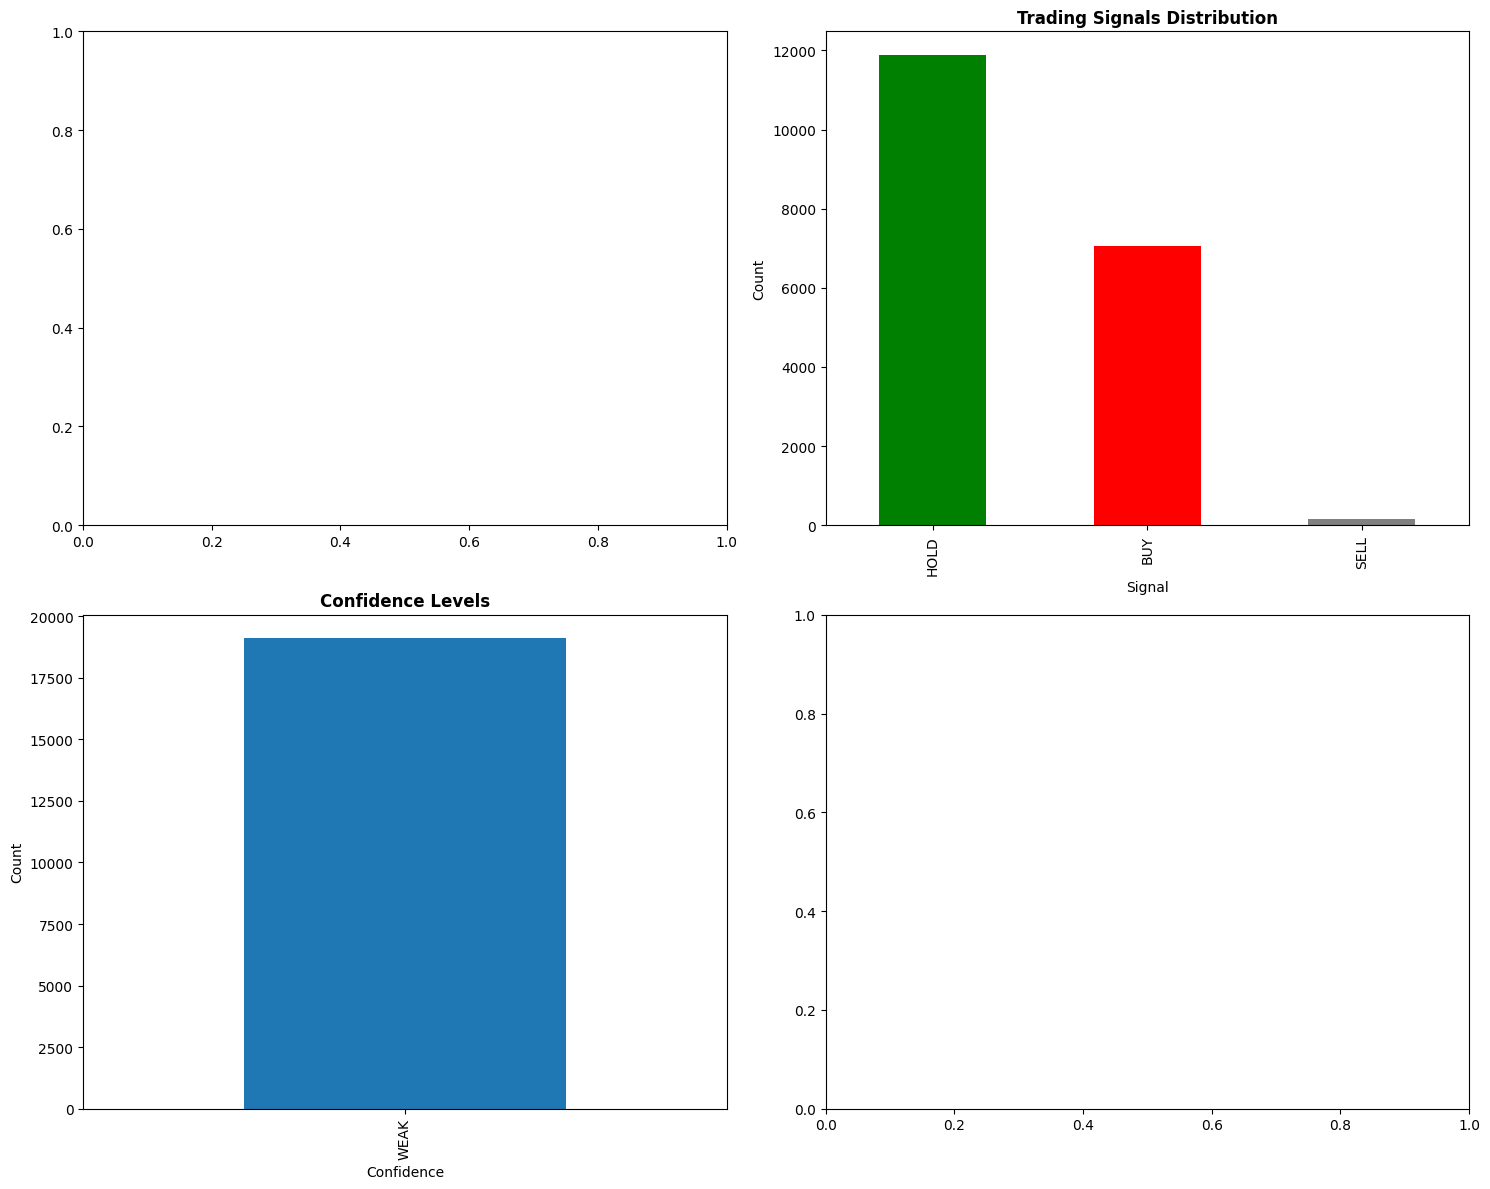


✅ Visualizations saved to 'visualizations/finbert_analysis.png'


In [30]:
# CELL 8: Visualize results
print("\n" + "="*80)
print("CELL 8: VISUALIZATION & RESULTS")
print("="*80)

# Create visualizations directory
import os
os.makedirs('visualizations', exist_ok=True)

# 1. Sentiment distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: FinBERT sentiment distribution
if 'finbert_label' in df_sample.columns:
    df_sample['finbert_label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'red', 'gray'])
    axes[0,0].set_title('FinBERT Sentiment Distribution', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Sentiment')
    axes[0,0].set_ylabel('Count')

# Plot 2: Trading signals distribution
if 'trading_signal' in df_sample.columns:
    df_sample['trading_signal'].value_counts().plot(kind='bar', ax=axes[0,1], color=['green', 'red', 'gray'])
    axes[0,1].set_title('Trading Signals Distribution', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Signal')
    axes[0,1].set_ylabel('Count')

# Plot 3: Confidence levels
if 'confidence' in df_sample.columns:
    df_sample['confidence'].value_counts().plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Confidence Levels', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Confidence')
    axes[1,0].set_ylabel('Count')

# Plot 4: Sentiment score distribution
if 'finbert_score' in df_sample.columns:
    df_sample['finbert_score'].hist(bins=20, ax=axes[1,1])
    axes[1,1].set_title('Sentiment Score Distribution', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Score')
    axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('visualizations/finbert_analysis.png', dpi=300)
plt.show()

print("\n✅ Visualizations saved to 'visualizations/finbert_analysis.png'")


## CELL 9: Export Results
 

In [31]:
# CELL 9: Export results to CSV
print("\n" + "="*80)
print("CELL 9: EXPORT RESULTS")
print("="*80)

# Select columns to export
export_cols = ['Content', 'Sentiment', 'finbert_label', 'finbert_score', 
               'trading_signal', 'confidence', 'stock_symbol']

# Only export columns that exist
available_cols = [col for col in export_cols if col in df_sample.columns]

# Export to CSV
output_file = 'finbert_predictions.csv'
df_sample[available_cols].to_csv(output_file, index=False)

print(f"\n✅ Results exported to '{output_file}'")
print(f"Total records: {len(df_sample)}")
print(f"\nColumns exported: {available_cols}")

# Show summary
print("\n[SUMMARY]")
print("="*80)
if 'accuracy' in locals():
    print(f"FinBERT Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Trading Signals Generated: {len(df_sample)}")
if 'trading_signal' in df_sample.columns:
    print(f"\nSignal Distribution:")
    print(df_sample['trading_signal'].value_counts())

print("\n" + "="*80)
print("PROJECT COMPLETED!")
print("="*80)



CELL 9: EXPORT RESULTS

✅ Results exported to 'finbert_predictions.csv'
Total records: 19100

Columns exported: ['Content', 'Sentiment', 'trading_signal', 'confidence', 'stock_symbol']

[SUMMARY]
FinBERT Accuracy: 0.3349 (33.49%)
Trading Signals Generated: 19100

Signal Distribution:
trading_signal
HOLD    11888
BUY      7049
SELL      163
Name: count, dtype: int64

PROJECT COMPLETED!
